In [1]:
from train import *
from model import *
from helpers import *

import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 2
num GPUs 2
num GPUs 2


In [2]:
names = []
images = []
image_size = (3, 128, 128)
fill_color = (255, 255, 255)
num_of_low_shots = 24
num_of_val = 24

for img in os.listdir('./pokemon/images/images'):
    im = Image.open('./pokemon/images/images/{}'.format(img))
    names.append(img.split('.')[0])
    im = im.convert("RGBA")
    if im.mode in ('RGBA', 'LA'):
        bg = Image.new(im.mode[:-1], image_size[1:], fill_color) # size = (128, 128, 3)
        bg.paste(im, im.split()[-1])
        im = bg

    images.append(np.asarray(im))
#     if len(images) == 800: # crop at 800 images
#         break
    
images = (np.asarray(images).astype(np.float32) / 255.0) / 2. + 0.5

In [3]:
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_var = np_to_var(mask_np).type(dtype) # float within 0~1

In [4]:
batch_size = 3
    
train_set = Pokeman(images[:num_of_low_shots], names[:num_of_low_shots])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, 
    shuffle=True, num_workers=8, pin_memory=False,
)


val_set = Pokeman(images[-num_of_val:], names[-num_of_val:])
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [6]:
code_dim = 128
Z = np.random.normal(size=(len(train_set), 1, code_dim)).astype(np.float32) # (number of low shots, 128)
Z = torch.tensor(Z, requires_grad=True).to(device)

LV_Z = LatentVariables(Z).to(device)
pre_decoder = Decoder(code_dim).to(device)

g = CombinedModel(LV_Z, pre_decoder).to(device)
g.apply(weight_init)
print(get_n_params(g))
print(g)

13248384
CombinedModel(
  (Z): LatentVariables()
  (Decoder): Decoder(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(

In [7]:
# prepare for pre-train
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

Xi_train, _, idx_train = (next(iter(train_loader))) # Xi_val: [3, 3, 128, 128]
imsave('low_shots.png', make_grid(Xi_train.cpu(), nrow=8).numpy().transpose(1, 2, 0))
train_image_index = np.arange(0, len(train_set))

In [8]:
# pre-train
epoch_for_pre = 1200
g, Z = pre_train(epoch_for_pre, 
                 train_loader, 
                 g, 
                 Z,
                 train_image_index,
                 optimizer, 
                 pre_decoder,
                  "./low_shots_pk/checkpoint/current_decoder_pre.pt")

Pre-train Epoch: 200 	 Average Loss: 0.005804
Pre-train Epoch: 400 	 Average Loss: 0.001421
Pre-train Epoch: 600 	 Average Loss: 0.000392
Pre-train Epoch: 800 	 Average Loss: 0.000203
Pre-train Epoch: 1000 	 Average Loss: 0.000135
Pre-train Epoch: 1200 	 Average Loss: 0.000102


In [10]:
torch.cuda.empty_cache()

In [8]:
# prepare for training
code_dim = 128
epoch_for_train_z = 1250
epoch_for_joint_train = 350

final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
final_z_dict = torch.zeros((len(val_set), 1, code_dim)).to(device)
psnr_list = np.zeros(len(val_set))

for i, (Xi_val, _, idx_val) in enumerate(val_loader):
    progress = tqdm(total=1, desc='loop % 3d' % i)
#     print('working on image', i)
    Xi_val = Variable(Xi_val).to(device)
    Xi_val_noisy = (Xi_val * mask_var).to(device)
    
    # load pre-trained decoder
    train_decoder = Decoder(code_dim).to(device)
    if os.path.isfile("./low_shots_pk/checkpoint/current_decoder_pre.pt"):
        train_decoder.load_state_dict(torch.load("./low_shots_pk/checkpoint/current_decoder_pre.pt"))
    else:
        train_decoder.apply(weight_init)
    
    # initial z
    target_z = sample_multivar_normal(Z)
    
    # combined model train_g
    LV_target_z = LatentVariables(target_z).to(device)
    train_g = CombinedModel(LV_target_z, train_decoder).to(device)
    
    # train phase: train z to find z_hat
    target_z_hat, _ = train(epoch_for_train_z, 
                            Xi_val_noisy, 
                            train_g, 
                            train_decoder, 
                            target_z, 
                            joint_train=False,
                            learning_rate=5 * 1e-4,
                            save_path="./low_shots_pk/checkpoint/current_checkpoint_train_z.pt",
                            mask=mask_var,
                            measure=None)

    # train phase: joint train
    warm_start_z = LatentVariables(target_z_hat).to(device)
    joint_train_g = CombinedModel(warm_start_z, train_decoder).to(device)
    
    final_z, final_G = train(epoch_for_joint_train, 
                         Xi_val_noisy, 
                         joint_train_g,
                         train_decoder, 
                         target_z_hat, 
                         joint_train=True,
                         learning_rate=1e-4,
                         save_path="./low_shots_pk/checkpoint/current_checkpoint_final.pt",
                         mask=mask_var,
                         measure=None)
    
    final_output[i] = final_G
    final_z_dict[i] = final_z
    psnr_list[i] = psnr(Xi_val.cpu().numpy(), final_output[idx_val].detach().cpu().numpy())
    
    progress.set_postfix({'loss': loss_fn(final_G * mask_var, Xi_val* mask_var).item()})
    progress.update()

In [9]:
imsave('results_with_shots.png', make_grid(final_output.detach().cpu(), nrow=8).numpy().transpose(1, 2, 0))
average_pnsr_with_shots = np.mean(psnr_list)
average_pnsr_with_shots

38.32232303122169

In [9]:
imsave('results.png', make_grid(final_output.detach().cpu(), nrow=8).numpy().transpose(1, 2, 0))
average_pnsr = np.mean(psnr_list)
average_pnsr

19.096580749451043

(-0.5, 127.5, 127.5, -0.5)

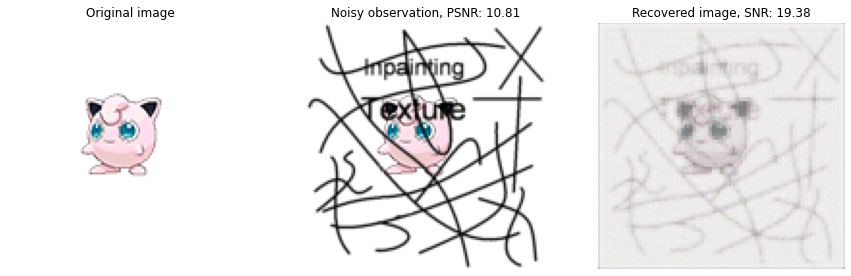

In [10]:
# visual results for inpainting task
Xi_val, _, idx = val_set[2]
Xi_val = Xi_val.to(device)
Xi_val_noisy = (Xi_val * mask_var).to(device)

def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, Xi_val)
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
myimgshow(ax2, Xi_val_noisy)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(Xi_val.cpu().numpy(), (Xi_val_noisy.cpu().numpy())))
ax2.axis('off')

ax3 = fig.add_subplot(133)
myimgshow(ax3, final_output[idx])
ax3.set_title( "Recovered image, PSNR: %.2f" % psnr(Xi_val.cpu().numpy(), final_output[idx].detach().cpu().numpy()) ) 
ax3.axis('off')

In [11]:
# visual results for inpainting task
def plot_all(plt, i):
    Xi_val, _, idx = val_set[i]
    Xi_val = Xi_val.to(device)
    
    fig = plt.figure(figsize = (15,15)) 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1, Xi_val)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2, Xi_val * mask_var)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(Xi_val.cpu().numpy(), (Xi_val.cpu().numpy() * mask_var.cpu().numpy())))
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3, final_output[idx])
    ax3.set_title( "Recovered image, SNR: %.2f" % psnr(Xi_val.cpu().numpy(), final_output[idx].detach().cpu().numpy()) ) 
    ax3.axis('off')

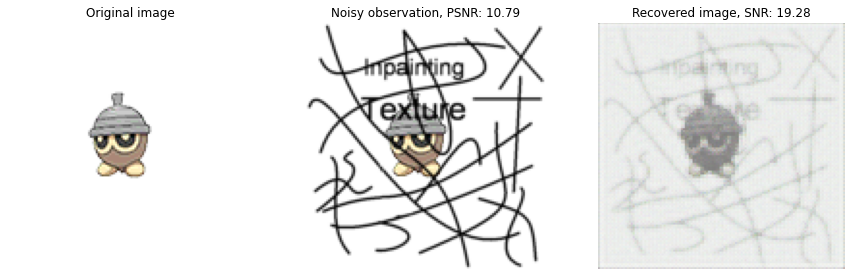

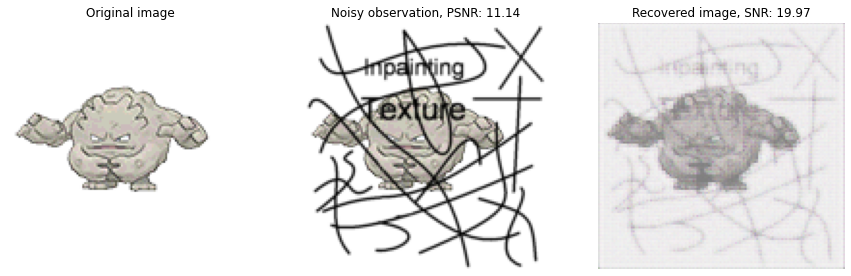

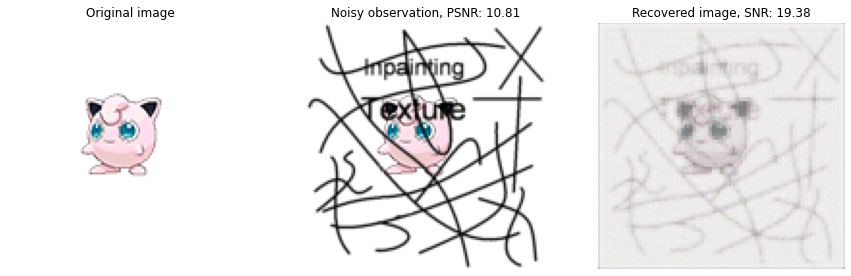

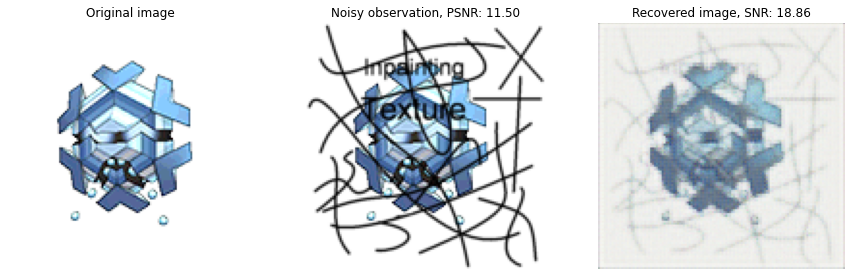

In [12]:
for i in range(0, 4):
    plot_all(plt, i)

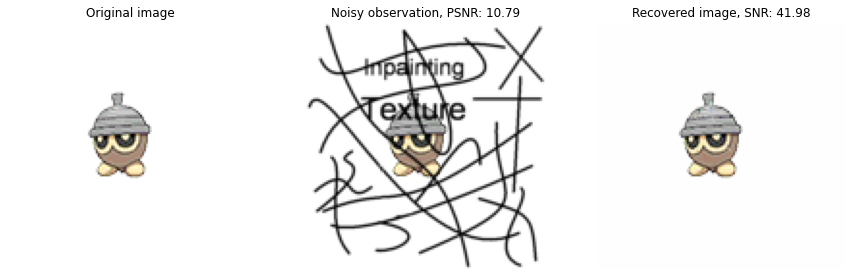

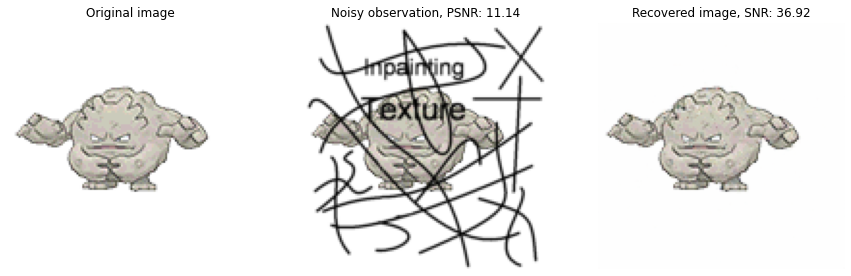

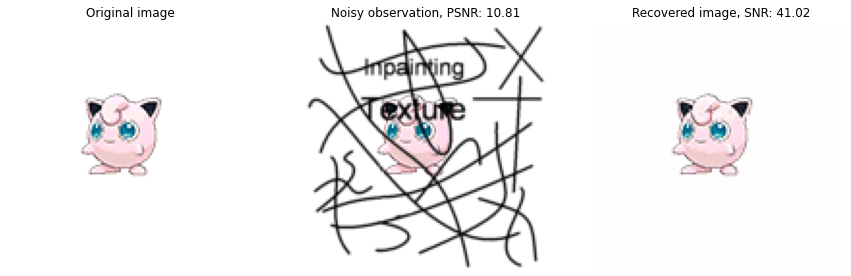

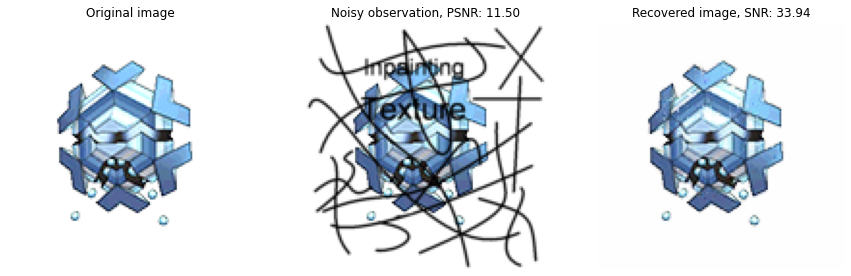

In [13]:
def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))
    
for i in range(0, 4):
    plot_all(plt, i)